# 0. Installation and Usage

## 0.1 External Installations 

In [2]:
%%bash
pip install -q gdown
pip install -q torch
pip install -q pytorch-lightning
pip install -q ultralytics
pip install -q ftfy regex tqdm
pip install -q git+https://github.com/openai/CLIP.git
pip install -q transformers==4.29
pip install -q sentencepiece==0.1.97

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try 'pacman -S
    python-xyz', where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Arch-packaged Python package,
    create a virtual environment using 'python -m venv path/to/venv'.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip.
    
    If you wish to install a non-Arch packaged Python application,
    it may be easiest to use 'pipx install xyz', which will manage a
    virtual environment for you. Make sure you have python-pipx
    installed via pacman.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detailed specification.
error: externally-managed-environment

× This environment is externally managed
╰

CalledProcessError: Command 'b'pip install -q gdown\npip install -q torch\npip install -q pytorch-lightning\npip install -q ultralytics\npip install -q ftfy regex tqdm\npip install -q git+https://github.com/openai/CLIP.git\npip install -q transformers==4.29\npip install -q sentencepiece==0.1.97\n'' returned non-zero exit status 1.

## 0.2 Data

In [ ]:
%%bash

# Download dataset from Google Drive
!gdown 1tkTUpbdkPqQ1JgHcVlsT0ikjcftF4P6x


unzip /content/refcocog.tar.zip
rm /content/refcocog.tar.zip

# Un-tar dataset and then remove tar file
tar -xvf /content/refcocog.tar
rm /content/refcocog.tar

## 0.3 Imports

In [12]:
import os
import numpy as np
import pandas as pd
import pprint

import pickle
from typing import Any, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchmetrics


import pytorch_lightning as pl
from pytorch_lightning.utilities.types import STEP_OUTPUT

from transformers import T5Tokenizer, T5ForConditionalGeneration 

from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import clip
from ultralytics import YOLO

# 1. Dataset

### 1.1 Dataset Class

In [4]:
from torch.utils.data import Dataset

import json

class RefCOCOg(Dataset):
    """
    Args:
        dataset: a list of dictionaries containing:
        {
            'file_name': # path of the image, images will be loaded on the fly
            'caption': # referring caption
            'ann_id': # annotation ID (one per caption), taken from 'file_name'
            'bbox': # coordinates (xmin, ymin, xmax, ymax) of the bounding box
        }
    """
    def __init__(self, refs, annotations, split="train"):

        self.dataset = [{"file_name": os.path.join("./refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg'),
                            "caption": elem["sentences"][0]["raw"],
                            "ann_id": int(elem["file_name"].split("_")[3][:-4]),
                            "bbox": annotations[int(elem["file_name"].split("_")[3][:-4])]}
                        for elem in [d for d in refs if d["split"]==split]]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

    def __call__(self, idx):
        print(json.dumps(self.dataset[idx], indent=4))

### 1.2 Load Refs and Annotations

In [5]:
# Load refs and annotations
import pickle

with open("./refcocog/annotations/refs(umd).p", "rb") as fp:
  refs = pickle.load(fp)

# 'annotations' will be a dict object mapping the 'annotation_id' to the 'bbox' to make search faster
with open("./refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  annotations = dict(sorted({ann["id"]: ann["bbox"] for ann in data["annotations"]}.items()))

### 1.3 DataLoader

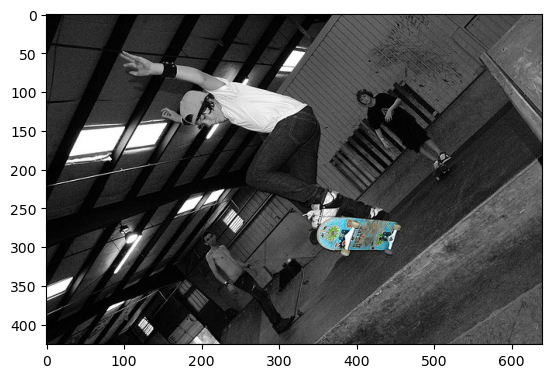

In [8]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import os

from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw

def pad_image(image):
    """
    Performs bottom-right padding of the original image to 640x640 (max size of images in the dataset).
    Bottom-right padding prevents corruption of bounding boxes.

    ### Arguments
    image: a PIL.Image to transform
    """
    original_width, original_height = image.size
    padded_width, padded_height = 640, 640

    pad_width = padded_width - original_width
    pad_height = padded_height - original_height

    padded_image = Image.new(image.mode, (padded_width, padded_height), (0, 0, 0))
    padded_image.paste(image, (0, 0))

    return padded_image

def collate_fn(batch):
    images = []
    for sample in batch:
        image = Image.open(sample["file_name"]).convert("RGB")
        image = pad_image(image=image)
        images.append(transform(image))
    images = torch.stack(images, dim=0) #Concatenates a sequence of tensors along a new dimension.

    data = {}
    for key in batch[0].keys():
        if key != "file_name":
            data[key] = [sample[key] for sample in batch]
    
    print(data)
    print("--------------------------")

    return images, data

transform = transforms.Compose([
    transforms.ToTensor(),
])

# create dataset and dataloader
dataset = RefCOCOg(refs, annotations, split="train")
plt.imshow(Image.open(dataset[2]["file_name"]))
dataloader = DataLoader(dataset, batch_size=1, collate_fn=collate_fn)


### Usage:

# for d in dataloader:

#     img = np.array(d[0][0].cpu().numpy().transpose(1, 2, 0)*255, dtype=np.uint8)
#     bbox = d[1]["bbox"][0]
#     img = Image.fromarray(img)
#     draw = ImageDraw.Draw(img)
#     draw.rectangle(((bbox[0], bbox[1]), (bbox[2]+bbox[0], bbox[3]+bbox[1])), width=3)

#     plt.imshow(img)
#     plt.show()
#     break

In [14]:
iter_loader = iter(dataloader)
batch1 = next(iter_loader)
pprint(batch1)

{'caption': ['Two woman one in black eatting and the other has a white shirt at the desk'], 'ann_id': [1241542], 'bbox': [[0.0, 45.95, 238.92, 408.64]]}
--------------------------


TypeError: 'module' object is not callable

### Utils

In [ ]:
import torch
import clip
from PIL import Image, ImageDraw
import cv2
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [1]:
def load_image_plt(path):
    """ Load image with matplotlib"""
    return plt.imread(path)

def load_image_pil(path):
    """ Load image with PIL"""
    return Image.open(path)

def get_distance_box_iou_accuracy(box_pred, box_true, iou_threshold=0.5):
    """
    Given the target boxes and the prediction return the
    accuracy of the prediction. The accuracy is computed as
    the percentage of boxes that have an IoU > iou_threshold
    with the target box.

    Args:
    @params box_pred: tensor of shape (batch_size, n_boxes, 4)
    @params box_true: tensor of shape (batch_size, n_boxes, 4)
    @params iou_threshold: float

    Returns:
    @params accuracy: float

    """

    iou = torchvision.ops.box_iou(box_pred, box_true).diagonal()
    giou = torchvision.ops.generalized_box_iou(box_pred, box_true).diagonal()

    return (iou > iou_threshold).float().mean(), iou.mean(), giou.mean()

### Baseline

In [15]:
class YoloClip():
    def __init__(self):

        self.yolo = torch.hub.load('ultralytics/yolov5', 'yolov5l6', pretrained=True)
        self.clip_model, self.clip_preprocess = clip.load("RN50", device=device)

    def infer_bboxes(self, image_path):
        results = self.yolo(image_path)
        bboxes = results.xyxy[0].cpu().numpy()
        return bboxes

    def encode_image(self, image):
        # Load and preprocess the image using CLIP preprocess function
        image = self.clip_preprocess(image).unsqueeze(0).to(self.device)

        # Encode the image using the CLIP model
        with torch.no_grad():
            image_features = self.clip_model.encode_image(image)

        return image_features

    def encode_text(self, text):
        # Encode the text using the CLIP model
        text = clip.tokenize(text).to(self.device)
        with torch.no_grad():
            text_features = self.clip_model.encode_text(text)

        return text_features

    def calculate_best_bbox(self, image_path, caption, device):
        text = clip.tokenize(caption).to(device)
        best_score = 0
        best_bbox = None

        for bbox in self.infer_bboxes(image_path):
            temp = cv2.imread(image_path)
            image = np.zeros((temp.shape[0], temp.shape[1], temp.shape[2]), dtype=np.uint8)
            image[int(bbox['ymin']):int(bbox['ymax']), int(bbox['xmin']):int(bbox['xmax'])] = temp[int(bbox['ymin']):int(bbox['ymax']), int(bbox['xmin']):int(bbox['xmax'])]
            image = Image.fromarray(image).to(device)

            with torch.no_grad():
                logits_per_image, logits_per_text = self.clip_model(image, text)
                matching_score = logits_per_text.cpu().numpy()[0]

            if matching_score > best_score:
                best_score = matching_score
                best_bbox = bbox

        return best_score, best_bbox

In [26]:
# Constants and models

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# YOLO
model_yolo = YOLO("yolov8x.pt")

# CLIP
clip_model, clip_preprocess = clip.load("RN50", device=device)

In [17]:
checkpoint="unikei/t5-base-split-and-rephrase"
t5_tokenizer = T5Tokenizer.from_pretrained(checkpoint)
t5_model = T5ForConditionalGeneration.from_pretrained(checkpoint).to(device)

In [18]:
class LinearBoxWeightingBlock(nn.Module):
    def __init__(self, n_head=2, number_transformer_layers=2, dropout=0.1, emb_size=128, max_num_boxes=3, dim_emb_clip=512):
        super().__init__()

        self.linear_1 = nn.Linear(2, emb_size)

        self.layernorm_1 = nn.LayerNorm([max_num_boxes, dim_emb_clip, emb_size])
        self.gelu = nn.GELU()

        self.linear_2 = nn.Linear(emb_size*dim_emb_clip, emb_size)

        # In our architecture the transformer encoder uses layer norm first.
        # According to the results of the paper 'On Layer Normalization in
        # the Transformer Architecture' the convergence is faster if layer
        # norm is done first.
        # source: https://arxiv.org/pdf/2002.04745.pdf
        self.transformer_encoder = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=emb_size, nhead=n_head, norm_first=True, batch_first=True, activation=F.gelu), num_layers=number_transformer_layers
            )

        # This layer combines the output of the transformer encoder
        # with the initial concatenated embedding. The result of this layer is
        # a single vector for each box.
        self.linear_3 = nn.Linear(emb_size, emb_size)
        self.layernorm_2 = nn.LayerNorm([max_num_boxes, emb_size])

        self.linear_4 = nn.Linear(emb_size, 1)

        self.dropout = nn.Dropout(dropout)


    def forward(self, x):
        x = x.permute(0, 3, 2, 1)                   # permute
        x = self.linear_1(x)                        # linear transformation
        x = self.gelu(x)                            # non-linearity
        x = self.layernorm_1(x)                     # norm
        x = x.flatten(start_dim=2, end_dim=-1)      # flatten
        x = self.linear_2(x)                        # linear transformation
        x = self.gelu(x)                            # non-linearity
        x = self.transformer_encoder(x)             # transformer encoder

        if self.training:
          x = self.linear_3(self.dropout(x))        # linear transformation
        else:
          x = self.linear_3(x)                      # linear transformation
        x = self.gelu(x)                            # non-linearity
        x = self.layernorm_2(x)                     # norm
        x = self.linear_4(x)                        # linear transformation

        return x

In [19]:
class CLIPscoreBlock(nn.Module):
    '''
    This block computes the batched clip score for each box.
    The input is the text embedding and the box embedding.
    The output is a tensor of shape (batch_size, n_boxes, 1)
    where each element is the score of the box.

    Args:
        @params text_emb: tensor of shape (batch_size, 512)
        @params box_emb: tensor of shape (batch_size, n_boxes, 512)

    Returns:
        @params returns x: tensor of shape (batch_size, n_boxes, 1)

    x:  [tex_0 @ box_1.T, tex_0 @ box_2.T, ..., tex_0 @ box_j]
        [tex_1 @ box_1.T, tex_1 @ box_2.T, ..., tex_1 @ box_j]
        [tex_2 @ box_1.T, tex_2 @ box_2.T, ..., tex_2 @ box_j]
                                ...
                                ...
        [tex_i @ box_1.T, tex_i @ box_2.T, ..., tex_i @ box_j]

    Normalizing over the rows and summing over the columns
    to get the overall score for each box.

    x summarize the matching in between the sentence and the boxes
    x: [sum(tex_[:] @ box_1.T), sum(tex_[:] @ box_2.T), ..., sum(tex_[:] @ box_j)]
    '''
    def __init__(self, n_box=48):
        super().__init__()
        self.n_box = n_box


    def forward(self, box_encoding, text_emb):

        x = torch.bmm(text_emb.squeeze(-1), box_encoding) # (B, D) @ (B, D)
        x = x.sum(dim=-2)

        return x

In [21]:
class FinetunedRephrasing(pl.LightningModule):
    def __init__(self, out_dim_box=512, latent_dim=240, hidden_dim_regressor=256):
        super().__init__()

        self.linWeighting = LinearBoxWeightingBlock()
        self.clipScoreBlock = CLIPscoreBlock()

        self.resizer = nn.Linear(1, 4)

        self.save_hyperparameters()

        # https://arxiv.org/pdf/2108.12627
        self.HUBER = nn.SmoothL1Loss()
        self.accuracy = get_distance_box_iou_accuracy

        # self.MSE = nn.MSELoss()
        # self.MAE = nn.L1Loss()
        # self.generalized_box_iou_loss = torchvision.ops.generalized_box_iou_loss
        # https://arxiv.org/abs/1911.08287
        # self.distance_box_iou_loss = torchvision.ops.distance_box_iou_loss
        # https://arxiv.org/abs/1902.09630
        # self.complete_box_iou_loss = torchvision.ops.complete_box_iou_loss

    def forward(self, x, box, text_emb):

        x_1 = self.clipScoreBlock(x[:,0,:,:], text_emb)

        # sort the boxes according to the similarity score
        _, idx = torch.sort(x_1, dim=1, descending=True)
        x = x.gather(3, idx.unsqueeze(-2).unsqueeze(-2).repeat(1, 2, 512, 1))[:,:,:,:3]
        x_1 = x_1.gather(1, idx)[:,:3].unsqueeze(-1)
        box = box.gather(1, idx.unsqueeze(-1).repeat(1, 1, 4))[:,:3]

        x = self.linWeighting(x)

        # shift the scores
        x = x_1 + x

        # box: (batch_size, 48, 1), (batch_size, 48, 4) -> (batch_size, 48, 5)
        x = torch.cat([x, box], dim=-1)

        # sort again the boxes according to the similarity score
        _, idx = torch.sort(x[:, :, 0], dim=1, descending=True)
        x = x.gather(1, idx.unsqueeze(-1).repeat(1, 1, 5))[:, 0, :]

        resize = self.resizer(x[:,0].unsqueeze(-1))

        return resize + x[:,1:]

    def training_step(self, batch, batch_idx):

        cat_emb_text, box, t_emb, target = batch

        pred = self(cat_emb_text, box, t_emb)

        huber_loss = self.HUBER(pred, target)

        accuracy, iou_mean, giou_mean = self.accuracy(pred, target)

        self.log('train_accuracy', accuracy, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('train_huber_loss', huber_loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('train_iou_mean', iou_mean, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('train_giou_mean', giou_mean, on_step = True, on_epoch = True, prog_bar = True, logger = True)

        return huber_loss * (1.4 - iou_mean)

    def validation_step(self, batch, batch_idx):
        cat_emb_text, box, t_emb, target = batch
        # print(cat_emb_text.shape, box.shape, y.shape)
        pred = self(cat_emb_text, box, t_emb)

        huber_loss = self.HUBER(pred, target)

        accuracy, iou_mean, giou_mean = self.accuracy(pred, target)

        self.log('train_accuracy', accuracy, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('train_huber_loss', huber_loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('train_iou_mean', iou_mean, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('train_giou_mean', giou_mean, on_step = True, on_epoch = True, prog_bar = True, logger = True)

        return huber_loss * (1.4 - iou_mean)


    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=0.5)
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20)
        return [optimizer], [scheduler]

In [22]:
class SentenceRephrase(nn.Module):
    def __init__(self, model, tokenizer, device, max_sents = 24):
        super(SentenceRephrase, self).__init__()
        # self.model = T5ForConditionalGeneration.from_pretrained(checkpoint).to(device)
        # self.tokenizer = T5Tokenizer.from_pretrained(checkpoint)

        self.model = model.to(device)
        self.model.eval()
        self.tokenizer = tokenizer
        self.device = device
        self.beam_size = max_sents # represent a good trade-off between quality and diversity


    def sentence_cut(sentence, t = 140):
        return sentence[:t] if len(sentence) > t  else sentence

    def forward(self, captions):

        print('Rephrasing sentences...')
        print('Original captions: ', captions)

        # move to device and tokenize the captions
        tokenized = self.tokenizer(captions,
                                padding="max_length",
                                truncation=True,
                                max_length=140,
                                return_tensors='pt')

        # generate the rephrased sentences
        simple_tokenized = self.model.generate(tokenized['input_ids'].to(device),
                                attention_mask = tokenized['attention_mask'].to(device),
                                max_length=140,
                                num_beams=self.beam_size,
                                num_return_sequences=self.beam_size-len(captions)
                            )

        # decode the generated sentences
        rephrased = self.tokenizer.batch_decode(simple_tokenized, skip_special_tokens=True)

        print('Rephrased captions: ', rephrased)

        # add to the original captions
        captions = captions + rephrased
        # cut sentences longer than 140 tokens
        t = 140
        captions = [sentence[:t] if len(sentence) > t else sentence for sentence in captions]

        return captions

In [23]:
class YOLOv8DetectorModule(nn.Module):
    def __init__(self, model, preprocess, device):
        super(YOLOv8DetectorModule, self).__init__()
        self.model_yolo = model
        self.preprocess = preprocess
        self.device = device

        # image normalization
        # mean-std input image normalization
        self.transform = transforms.Compose([
                                transforms.Resize(800),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ])

    def get_crops(self, yolov8_df, image):
        """ Get crops of the image from yolov8_df

        Args:
            yolov8_df (pd.DataFrame): DataFrame with yolov5 predictions
            image (np.array): image as np.array

        Returns:
            list: crops

        """
        crops = []
        image = image

        for box in yolov8_df.values:
            x_min, y_min, x_max, y_max, confidence = box[:5]

            if confidence > 0.5:
                crop = image[int(y_min):int(y_max), int(x_min):int(x_max)]
                crop = Image.fromarray((crop * 255).astype(np.uint8))
                crops.append(crop)

        # add the entire image
        crops.append(Image.fromarray(image))

        return crops

    def get_crops_preprocessed_for_clip(self, yolov8_df, image):
        """ Get crops from yolov8_df and preprocess them for CLIP

        Args:
            yolov8_df (pd.DataFrame): DataFrame with yolov5 predictions
            image (np.array): image as np.array

        Returns:
            torch.tensor: preprocessed crops

        """
        crops = []
        boxes = []
        image = image

        for box in yolov8_df.values:
            x_min, y_min, x_max, y_max, confidence = box[:5]
            if confidence > 0.3:
                crop = image[int(y_min):int(y_max), int(x_min):int(x_max)]
                crop = Image.fromarray((crop * 255).astype(np.uint8))#.convert('RGB')
                crop = self.preprocess(crop)
                crops.append(crop)
                boxes.append(torch.tensor([x_min, y_min, x_max, y_max]).type(torch.float32).unsqueeze(0))

        return torch.stack(crops).to(self.device), torch.cat(boxes).to(self.device)

    def plot_image_yolov8(self, results, image):
        """Plot the images with the boxes"""
        for i in results.xyxy[0]:
            if i[4] > 0.5: # if confidence is greater than 0.5
                # Create figure and axes
                _, ax = plt.subplots()

                boxes = i[:4]

                # Display the image
                ax.imshow(image)

                # Create a Rectangle patch
                x_min, y_min, width, height = boxes.tolist()
                ax.add_patch(Rectangle((x_min, y_min), width-x_min, height-y_min, linewidth=1, edgecolor='r', facecolor='none'))

                ax.axes.xaxis.set_visible(False)
                ax.axes.yaxis.set_visible(False)

                plt.show()

    def plot_image_bbox(self, boxes, images, captions):
        """Plot the images with the boxes"""
        for bbox, image, c in zip(boxes.tolist(), images, captions):
              # Create figure and axes
              _, ax = plt.subplots()

              # Display the image
              ax.imshow(image)

              # Create a Rectangle patch
              x_min, y_min, width, height = bbox
              ax.add_patch(Rectangle((x_min, y_min), width-x_min, height-y_min, linewidth=1, edgecolor='r', facecolor='none'))

              ax.axes.xaxis.set_visible(False)
              ax.axes.yaxis.set_visible(False)

              plt.title(c[0])

              plt.show()

    def forward(self, images_path):

        print('Detecting objects in the images...')
        # get yolov8 predictions
        results = self.model_yolo([load_image_pil(i) for i in images_path])

        print('Boxes detected!')

        # store the predictions into a dataframe
        results = [pd.DataFrame(result.boxes.boxes.tolist(), columns=['x_min', 'y_min', 'x_max', 'y_max', 'confidence', 'class']) for result in results]

        print('Preprocessing crops with CLIP...')

        # preprocess the images for CLIP
        cropPreprocessed_boxes = [
            self.get_crops_preprocessed_for_clip(yolov8_df, image)
                    for yolov8_df, image in zip(results, [load_image_plt(i) for i in images_path])
                ]

        imgs_preproc = [i[0] for i in cropPreprocessed_boxes]
        yolo_boxes = [i[1] for i in cropPreprocessed_boxes]

        if len(yolo_boxes) == 1:
            yolo_boxes = yolo_boxes[0].unsqueeze(0).to(torch.float32)
            imgs_preproc = imgs_preproc[0].unsqueeze(0).to(torch.float32)
        else:
            yolo_boxes = torch.cat(yolo_boxes).to(torch.float32)
            imgs_preproc = torch.cat(imgs_preproc).to(torch.float32)

        return imgs_preproc, yolo_boxes

In [24]:
class RephrasingDetectorModel(pl.LightningModule):
    def __init__(self, clip_model, clip_tokenizer, yolo_module, rephraser_module, finetuned_model, device):
        super().__init__()

        self.clip_model = clip_model
        self.clip_tokenizer = clip_tokenizer
        self.yolo_module = yolo_module
        self.rephraser_module = rephraser_module
        self.finetuned_model = finetuned_model


    def get_image_features(self, images):
        """Get the clip image features"""

        print('Encoding images...')

        with torch.no_grad():
            image_features = self.clip_model.encode_image(images)
        # Normalize features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        return image_features

    def get_text_features(self, text):
        """Get the clip text features"""

        print('Encoding text...')

        with torch.no_grad():
            text_features = self.clip_model.encode_text(self.clip_tokenizer([t for t in text]).to(device))
        # Normalize features
        text_features /= text_features.norm(dim=-1, keepdim=True)
        return text_features

    def get_score_similarities(self, image_features, text_features):
        """Get the clip similarities"""
        # Calculate similarity
        similarities = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        return similarities

    def detector_inference(self, images):
        # get preprocessed crops of the objects
        # in the original images
        x = [self.yolo_module(image) for image in images]
        max_crop_shape = max([crop[1].shape[1] for crop in x])
        imgs_crops, yolo_boxes = [crop[0] for crop in x], torch.cat([torch.nn.functional.pad(crop[1], (0, 0, max_crop_shape-crop[1].shape[1], 0)) for crop in x])
        return imgs_crops, yolo_boxes

    def box_norm_rescale(self, box_target):
        """ Rescale the box_target
        Args:
            box_target: (number of samples, 1, 4)

        Returns:
            box_target: (number of samples, 1, 4)

        """
        # convert the box_pred to x1, y1, x2, y2
        box_target[:, 0, 2] = box_target[:, 0, 0] + box_target[:, 0, 2]
        box_target[:, 0, 3] = box_target[:, 0, 1] + box_target[:, 0, 3]

        return box_target


    def forward(self, x, captions):
        """Forward pass"""

        # get the preprocessed crops of the objects in
        # the original images
        imgs_crops, yolo_boxes = self.detector_inference(x)

        # rephrase the captions
        if len(captions) == 1:
            captions = [self.rephraser_module.forward(captions)]
        else:
            captions = [self.rephraser_module.forward(caption) for caption in captions]

        print('Extracting features with CLIP...')

        # extract the clip text features
        caption_features = torch.stack(
            [self.get_text_features(caption) for caption in captions]
          ).unsqueeze(-1).to(torch.float32)

        # extract the clip image features
        images_features = [self.get_image_features(img_crops.squeeze(0)).unsqueeze(0) for img_crops in imgs_crops]
        max_shape = max([crops.shape[1] for crops in images_features])
        images_features = torch.cat([torch.nn.functional.pad(crops, (0, 0, max_shape-crops.shape[1], 0)) for crops in images_features]).permute(0, 2, 1).unsqueeze(1).to(torch.float32)


        print('Prepare the data...')

        # concatenate the image and text features
        cat_img_txt_features = torch.cat(
            [images_features, caption_features.squeeze(-1)[:,0,:].unsqueeze(1).unsqueeze(-1).repeat(1, 1, 1, images_features.shape[3])], dim=1
            ).to(torch.float32)

        # check that the number of boxes are > 3
        if cat_img_txt_features.shape[3] < 3:
            # pad the tensor with zeros
            cat_img_txt_features = torch.cat(
                [cat_img_txt_features, torch.zeros(cat_img_txt_features.shape[0], cat_img_txt_features.shape[1], cat_img_txt_features.shape[2], 3 - cat_img_txt_features.shape[3]).to(device)], dim=3
              )

        yolo_boxes = self.box_norm_rescale(yolo_boxes)

        pred = self.finetuned_model.forward(cat_img_txt_features, yolo_boxes, caption_features)

        return pred

In [29]:
sentence_rephrase_module = SentenceRephrase(t5_model, t5_tokenizer, device).to(device)
yolo_detector_module = YOLOv8DetectorModule(model_yolo, clip_preprocess, device).to(device)

fine_tuned_model = FinetunedRephrasing().to(device)
#fine_tuned_model = fine_tuned_model.load_from_checkpoint('./c2lip-box_simpified_128-epoch=70-val_loss=0.00-other_metric=0.00.ckpt')

model_finetuned = RephrasingDetectorModel(clip_model, clip.tokenize, yolo_detector_module, sentence_rephrase_module, fine_tuned_model, device)

# count the number of parameters
print(f"Number of parameters: {sum(p.numel() for p in model_finetuned.parameters() if p.requires_grad)/1000000} M")

dataset = RefCOCOg(refs, annotations, split="test")
# dataset = RefCOCOg(refs, annotations, split="val")

interval = np.arange(30, 3000, 300)

path_imgs = [[dataset[i]['file_name']] for i in interval]
captions = [[dataset[i]['caption']] for i in interval]


bboxes_pred = model_finetuned(path_imgs, captions).detach().cpu()


0: 640x480 2 persons, 1 sandwich, 39.2ms
Speed: 2.9ms preprocess, 39.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.

0: 448x640 3 persons, 2 ties, 1 bottle, 4 cups, 4 chairs, 33.9ms
Speed: 1.7ms preprocess, 33.9ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.



Number of parameters: 334.89649 M
Detecting objects in the images...
Boxes detected!
Preprocessing crops with CLIP...
Detecting objects in the images...
Boxes detected!
Preprocessing crops with CLIP...
Detecting objects in the images...


0: 448x640 1 person, 1 tv, 1 laptop, 33.6ms
Speed: 1.2ms preprocess, 33.6ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.

0: 480x640 5 spoons, 5 bowls, 7 chairs, 2 potted plants, 1 dining table, 1 vase, 37.7ms
Speed: 1.4ms preprocess, 37.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.



Boxes detected!
Preprocessing crops with CLIP...
Detecting objects in the images...
Boxes detected!
Preprocessing crops with CLIP...
Detecting objects in the images...


0: 448x640 4 horses, 34.5ms
Speed: 1.6ms preprocess, 34.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.

0: 416x640 1 knife, 2 sandwichs, 32.6ms
Speed: 1.6ms preprocess, 32.6ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.

0: 480x640 1 person, 1 cup, 1 spoon, 3 bowls, 1 toothbrush, 35.6ms
Speed: 2.3ms preprocess, 35.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.



Boxes detected!
Preprocessing crops with CLIP...
Detecting objects in the images...
Boxes detected!
Preprocessing crops with CLIP...
Detecting objects in the images...
Boxes detected!
Preprocessing crops with CLIP...
Detecting objects in the images...


0: 480x640 2 elephants, 35.7ms
Speed: 1.6ms preprocess, 35.7ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.

0: 384x640 1 person, 3 bottles, 3 cups, 2 forks, 1 knife, 3 spoons, 2 bowls, 1 apple, 1 sandwich, 1 cake, 5 chairs, 1 dining table, 29.6ms
Speed: 1.2ms preprocess, 29.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.

0: 448x640 3 bottles, 12 cups, 1 knife, 2 bowls, 2 cakes, 1 dining table, 32.1ms
Speed: 1.2ms preprocess, 32.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


Boxes detected!
Preprocessing crops with CLIP...
Detecting objects in the images...
Boxes detected!
Preprocessing crops with CLIP...
Detecting objects in the images...
Boxes detected!
Preprocessing crops with CLIP...
Rephrasing sentences...
Original captions:  ['grey table top']
Rephrased captions:  ['Grey table top. Table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table top grey table', 'Grey table top. Table top grey. Grey table top grey table top grey table top grey table top grey table top grey table top grey table

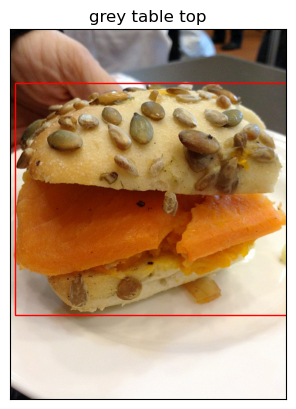

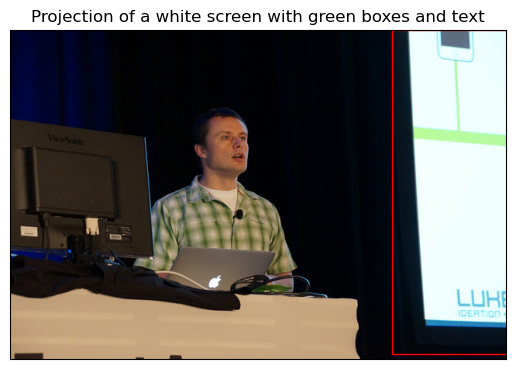

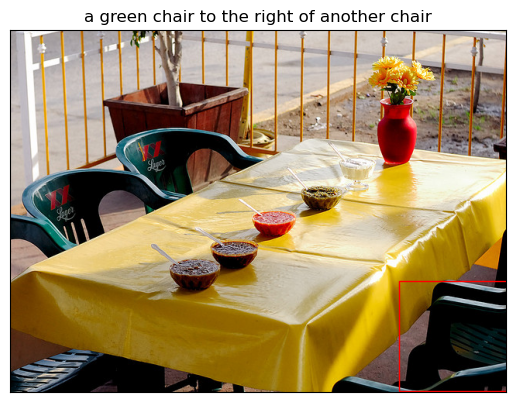

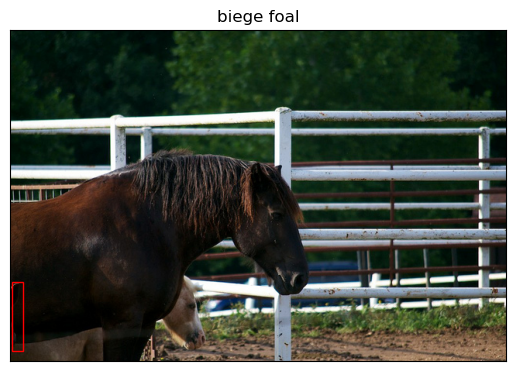

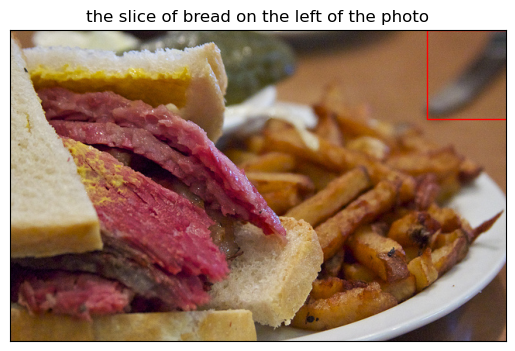

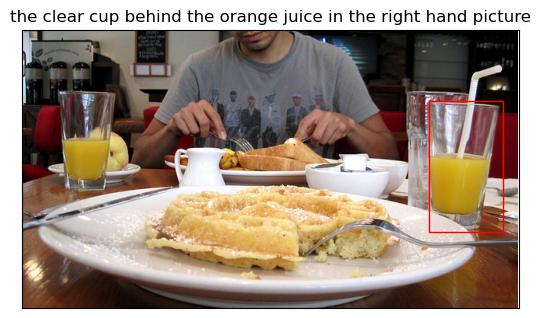

In [30]:
images = [load_image_pil(i[0]) for i in path_imgs]
yolo_detector_module.plot_image_bbox(bboxes_pred, images, captions)